In [1]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

#@save
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

正在从
http://d2l-data.s3-accelerate.amazonaws.com/VOCtrainval_11-May-2012.tar
下载..\data\VOCtrainval_11-May-2012.tar...


In [2]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [3]:
print("voc_dir:",voc_dir)

voc_dir: ..\data\VOCdevkit/VOC2012


In [4]:
def read_voc_images(voc_dir, is_train=True):
    # 读取所有VOC图像并标注
    txt_fname = os.path.join(
        voc_dir, 'ImageSets', 'Segmentation', 'train.txt' if is_train else 'val.txt'
    )
    # txt_fname: ..\data\VOCdevkit/VOC2012\ImageSets\Segmentation\train.txt
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(
            torchvision.io.read_image(
                os.path.join(
                    voc_dir,
                    'JPEGImages',
                    f'{fname}.jpg'
                )
            )
        )
        labels.append(
            torchvision.io.read_image(
                os.path.join(
                    voc_dir,
                    'SegmentationClass',
                    f'{fname}.png'
                ),
                mode
            )
        )
    return features, labels

'''

`torchvision.io.image.ImageReadMode` 是 `torchvision` 库中的一个枚举类，它定义了不同的图像读取模式。常见的模式包括：

- `RGB`: 读取彩色图像，具有红、绿、蓝三个通道。
- `GRAYSCALE`: 读取灰度图像，只有一个通道。
- `UNCHANGED`: 以原始格式读取图像，不进行任何转换。


在语义分割任务中，标注图像通常是带有不同颜色的图像，每种颜色表示不同的类别。
将标注图像读取为 `RGB` 模式，可以确保颜色信息的准确性，
从而正确识别和处理每个类别。例如，在标注图像中，
不同的像素颜色可能代表不同的物体类别，这对于训练语义分割模型至关重要。


`mode = torchvision.io.image.ImageReadMode.RGB` 设置了读取图像的模式为 `RGB`，
确保图像数据包含红、绿、蓝三个通道，这是在处理彩色图像时常用的模式。
对于语义分割任务，这样读取标注图像有助于保持颜色信息的准确性，
从而正确分类不同的物体类别。

'''

'\n\n`torchvision.io.image.ImageReadMode` 是 `torchvision` 库中的一个枚举类，它定义了不同的图像读取模式。常见的模式包括：\n\n- `RGB`: 读取彩色图像，具有红、绿、蓝三个通道。\n- `GRAYSCALE`: 读取灰度图像，只有一个通道。\n- `UNCHANGED`: 以原始格式读取图像，不进行任何转换。\n\n\n在语义分割任务中，标注图像通常是带有不同颜色的图像，每种颜色表示不同的类别。\n将标注图像读取为 `RGB` 模式，可以确保颜色信息的准确性，\n从而正确识别和处理每个类别。例如，在标注图像中，\n不同的像素颜色可能代表不同的物体类别，这对于训练语义分割模型至关重要。\n\n\n`mode = torchvision.io.image.ImageReadMode.RGB` 设置了读取图像的模式为 `RGB`，\n确保图像数据包含红、绿、蓝三个通道，这是在处理彩色图像时常用的模式。\n对于语义分割任务，这样读取标注图像有助于保持颜色信息的准确性，\n从而正确分类不同的物体类别。\n\n'

In [5]:
train_features, train_labels = read_voc_images(voc_dir, True)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

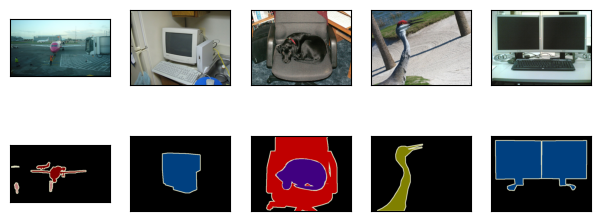

In [6]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs, 2, n)

In [7]:
# 列举RGB颜色
#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [16]:
def voc_colormap2label():
    # 构建从RGB到VOC类别索引的映射。
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        '''
        i: 0
        colormap: [0, 0, 0]
        i: 1
        colormap: [128, 0, 0]
        ...
        i: 19
        colormap: [128, 192, 0]
        i: 20
        colormap: [0, 64, 128]
        '''
        colormap2label[
            (
                colormap[0] * 256 + colormap[1]
            ) * 256 + colormap[2]
        ] = i
    return colormap2label

In [17]:
def voc_label_indices(colormap, colormap2label):
    # 将VOC标签中的RGB值映射到它们的类别索引
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = (
        (
            colormap[:, :, 0] * 256 + colormap[:, :, 1]
        ) * 256 + colormap[:, :, 2]
    )
    return colormap2label[idx]


In [18]:
y = voc_label_indices(
    train_labels[0],
    voc_colormap2label()
)
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

预处理数据

In [11]:
# 从给定的图像和标签中随机裁剪出一定尺寸的子图，并将这些子图展示出来。
def voc_rand_crop(feature, label, height, width):
    '''
    随机采集按特征和标签图像
    
    `torchvision.transforms.RandomCrop.get_params` 
    获取一个随机裁剪区域的参数 `rect`，
    这个裁剪区域的大小为 `(height, width)`，并且保证在 `feature` 图像内。

    `torchvision.transforms.functional.crop` 
    根据 `rect` 参数裁剪 `feature` 图像。

    torchvision.transforms.functional.crop(label, *rect)
    - 使用同样的方法裁剪 `label` 图像。

    '''
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width)
    )
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

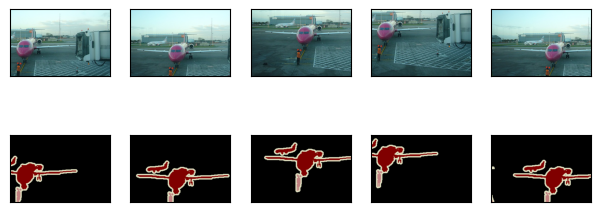

In [12]:
imgs = []
'''
- 每次循环调用 `voc_rand_crop` 函数对
`train_features[0]` 和 `train_labels[0]` 进行随机裁剪，
裁剪区域大小为 200x300。将裁剪后的特征图像和标签图像添加到 `imgs` 列表中。

'''
for _ in range(n):
    imgs += voc_rand_crop(
        train_features[0],train_labels[0], 200, 300
    )

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n)

自定义语义分割数据集类

In [19]:
class VOCSegDataset(torch.utils.data.Dataset):
    # 一个用于加载voc数据集的定义数据集
    def __init__(self, is_train, crop_size, voc_dir):
        '''
        - 定义图像标准化的变换，使用 ImageNet 数据集的均值和标准差。
        '''
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        self.crop_size = crop_size
        
        # 调用 `read_voc_images` 函数读取 VOC 数据集中的图像和标签。
        feature, labels = read_voc_images(voc_dir, is_train=is_train)
        
        '''
        对每张图像进行过滤和标准化处理，
        并将处理后的图像保存到 `self.features` 中。
        '''
        self.features = [
            self.normalize_image(feature)
            for feature in self.filter(feature)
        ]
        
        '''
        对标签进行过滤，并将处理后的标签保存到 `self.labels` 中。
        '''
        self.labels = self.filter(labels)

        # 调用 `voc_colormap2label` 函数，构建从 RGB 值到类别索引的映射表。
        self.colormap2label = voc_colormap2label()
         # - 打印读取的图像数量。
        print('read ' + str(len(self.features)) + ' examples')

    # 图像标准化 对图像进行标准化处理。
    def normalize_image(self, img):
        '''
        将图像从整数转换为浮点数并归一化到 [0, 1] 范围，然后应用标准化变换。
        '''
        return self.transform(img.float() / 255)

    # 图像过滤 定义 `filter` 方法，过滤掉尺寸小于裁剪尺寸的图像。
    def filter(self, imgs):
        '''
        使用列表生成式过滤图像，保留高度和宽度均大于等于裁剪尺寸的图像。
        '''
        return [
            img for img in imgs if(
                img.shape[1] >= self.crop_size[0] and
                img.shape[2] >= self.crop_size[1]
            )
        ]
    # 获取图像和标签
    # - 定义 `__getitem__` 方法，允许通过索引获取数据集中的元素。
    def __getitem__(self, idx):
        # 调用 `voc_rand_crop` 函数，对指定索引的图像和标签进行随机裁剪。
        feature, label = voc_rand_crop(
            self.features[idx],
            self.labels[idx],
            *self.crop_size
        )
        '''
        将裁剪后的图像和映射后的标签返回。
        `voc_label_indices` 函数将标签图像中的 RGB 值转换为类别索引。
        '''
        return (
            feature, voc_label_indices(label, self.colormap2label)
        )

    def __len__(self):
        return len(self.features)

'''
`VOCSegDataset` 实现了以下功能：

1. **初始化**：读取图像和标签，进行标准化和过滤处理，并构建 RGB 到类别索引的映射。
2. **图像标准化**：将图像归一化到 [0, 1] 范围并进行标准化处理。
3. **图像过滤**：过滤掉尺寸小于裁剪尺寸的图像。
4. **获取元素**：通过随机裁剪获取指定索引的图像和标签，并将标签中的 RGB 值转换为类别索引。
5. **数据集大小**：返回数据集中图像的数量。

这些功能使得该数据集类适用于语义分割任务，并能够方便地进行数据增强和预处理。

'''

读取数据集

In [20]:
crop_size = (320, 480)
voc_tain = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples
